## Notebook to analyze the data

In [1]:
import os
import csv
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

plt.rcParams['font.family'] = 'Times New Roman'

[nltk_data] Downloading package punkt to /users/eleves-a/2024/tim-
[nltk_data]     luka.horstmann.m2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /users/eleves-a/2024/tim-
[nltk_data]     luka.horstmann.m2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Define paths
repo_path = "original_repo"
tables_path = os.path.join(repo_path, "data/all_csv/")
statements_path = os.path.join(repo_path, "tokenized_data/")

# Load JSON data
def load_json_data(filepath):
    with open(filepath, "r") as f:
        return json.load(f)

# Logging for bad lines
bad_lines_log = []

# Function to process a single dataset split
def process_data(split_name):
    split_statements = load_json_data(os.path.join(statements_path, f"{split_name}_examples.json"))
    rows = []
    
    for table_id, statement_data in tqdm(split_statements.items(), desc=f"Processing {split_name} dataset"):
        # Load the table CSV
        table_path = os.path.join(tables_path, table_id)
        if not os.path.exists(table_path):
            print(f"Warning: Table {table_id} does not exist!")
            continue

        try:
            table_df = pd.read_csv(table_path, sep="#") #, on_bad_lines="skip")  # Skip bad lines
        except pd.errors.ParserError as e:
            print(f"Error reading {table_id}: {e}")
            bad_lines_log.append({"table_id": table_id, "error": str(e)})
            continue
        
        # Extract statements, labels, and metadata
        statements = statement_data[0]
        labels = statement_data[1]
        metadata = statement_data[2]

        # get row (incl. header) anc column lengths
        row_len = len(table_df)
        col_len = len(table_df.columns)

        # Add rows to the DataFrame
        for statement, label in zip(statements, labels):
            rows.append({
                "split": split_name,
                "table_id": table_id,
                "statement": statement,
                "label": label,
                "metadata": metadata,
                "table_data": table_df.to_dict(orient="records"),  # Store table as a list of dictionaries
                "row_len": row_len,
                "col_len": col_len
            })
    return rows

# Process all splits (train, validation, test)
all_rows = []
for split in ["train", "val", "test"]:
    all_rows.extend(process_data(split))

# Create a DataFrame
df = pd.DataFrame(all_rows)

# Save the bad lines log
if bad_lines_log:
    with open("bad_lines_log.json", "w") as log_file:
        json.dump(bad_lines_log, log_file, indent=4)

# Display the DataFrame structure
df.head()

Processing train dataset:   0%|          | 0/13182 [00:00<?, ?it/s]

Processing val dataset:   0%|          | 0/1696 [00:00<?, ?it/s]

Processing test dataset:   0%|          | 0/1695 [00:00<?, ?it/s]

,split,table_id,statement,label,metadata,table_data,row_len,col_len
0,train,2-15401676-3.html.csv,haroldo be mention as a brazil scorer for 2 di...,1,1919 in brazilian football,"[{'date': 'may 11 , 1919', 'result': 'w', 'sco...",5,5
1,train,2-15401676-3.html.csv,4 of the 5 game be for the south american cham...,1,1919 in brazilian football,"[{'date': 'may 11 , 1919', 'result': 'w', 'sco...",5,5
2,train,2-15401676-3.html.csv,friedenreich be mention as a brazil scorer for...,1,1919 in brazilian football,"[{'date': 'may 11 , 1919', 'result': 'w', 'sco...",5,5
3,train,2-15401676-3.html.csv,there be 2 different game where the highest sc...,1,1919 in brazilian football,"[{'date': 'may 11 , 1919', 'result': 'w', 'sco...",5,5
4,train,2-15401676-3.html.csv,4 of the 5 game be play in may 1919,1,1919 in brazilian football,"[{'date': 'may 11 , 1919', 'result': 'w', 'sco...",5,5


#### Build same table as Table 1 in paper

In [26]:
def summarize_tabfact(df):
    summary = []

    for split_name in df["split"].unique():
        split_df = df[df["split"] == split_name]
        num_tables = split_df["table_id"].nunique()
        num_sentences = len(split_df)
        avg_sentence_length = split_df["statement"].apply(lambda x: len(x.split())).mean()
        
        # Use pre-calculated row and column lengths
        avg_rows = split_df["row_len"].mean()
        avg_cols = split_df["col_len"].mean()
        
        summary.append({
            "Split": split_name.capitalize(),
            "# Sentences": num_sentences,
            "# Tables": num_tables,
            "Avg. Sentence Length": f"{avg_sentence_length:.2f}",
            "Avg. Rows": f"{avg_rows:.1f}",
            "Avg. Cols": f"{avg_cols:.1f}"
        })

    # Add total summary
    total_sentences = len(df)
    total_tables = df["table_id"].nunique()
    total_avg_length = df["statement"].apply(lambda x: len(x.split())).mean()
    total_avg_rows = df["row_len"].mean()
    total_avg_cols = df["col_len"].mean()
    
    summary.append({
        "Split": "Total",
        "# Sentences": total_sentences,
        "# Tables": total_tables,
        "Avg. Sentence Length": f"{total_avg_length:.2f}",
        "Avg. Rows": f"{total_avg_rows:.1f}",
        "Avg. Cols": f"{total_avg_cols:.1f}"
    })
    
    summary_df = pd.DataFrame(summary)
    # print(summary_df)
    print(summary_df.to_latex(index=False))

# Call the summarize function
summarize_tabfact(df)

\begin{tabular}{lrrlll}
\toprule
Split & # Sentences & # Tables & Avg. Sentence Length & Avg. Rows & Avg. Cols \\
\midrule
Train & 92283 & 13182 & 13.67 & 13.4 & 6.3 \\
Val & 12792 & 1696 & 14.05 & 13.6 & 6.3 \\
Test & 12779 & 1695 & 14.06 & 13.3 & 6.2 \\
Total & 117854 & 16573 & 13.75 & 13.4 & 6.3 \\
\bottomrule
\end{tabular}



### Analyze label distribution:

In [11]:
fontsize_plot = 14
def analyze_label_distribution(df):
    summary = []

    # Analyze label distribution for each split
    for split_name in df["split"].unique():
        split_df = df[df["split"] == split_name]
        label_counts = split_df["label"].value_counts()
        total_count = label_counts.sum()

        # Append to summary
        summary.append({
            "Split": split_name.capitalize(),
            **label_counts.to_dict()  # Convert label counts to dictionary
        })

        # Plotting for each split
        plt.figure(figsize=(3.5, 3))  # Horizontally narrower plots
        ax = label_counts.plot(kind="bar", color=["skyblue", "orange"])

        # Styling
        plt.title(f"{split_name.capitalize()} Data", fontsize=fontsize_plot+8)
        plt.xticks(ticks=[0, 1], fontsize=fontsize_plot+4, rotation=0)
        plt.yticks(fontsize=fontsize_plot+4)
        plt.xlabel("", fontsize=fontsize_plot+6)
        plt.ylabel("Count", fontsize=fontsize_plot+6)
        plt.tight_layout()

        # Add percentage labels
        for bar in ax.patches:
            percentage = f"{(bar.get_height() / total_count) * 100:.1f}"  # Calculate percentage
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar
                bar.get_height()/2,              # Y-coordinate slightly above the bar
                percentage,                        # Text to display
                ha="center",                       # Center alignment
                fontsize=fontsize_plot+4                        # Font size
            )

        # Save the figure for LaTeX
        plt.savefig(f"plots/label_dist/label_distribution_{split_name}.pdf", dpi=300)
        plt.close()

    # Analyze total label distribution
    total_label_counts = df["label"].value_counts()
    total_count = total_label_counts.sum()
    summary.append({
        "Split": "Total",
        **total_label_counts.to_dict()
    })

    # Plotting for total
    plt.figure(figsize=(3.5, 3))  # Horizontally narrower plots
    ax = total_label_counts.plot(kind="bar", color=["skyblue", "orange"])
    
    # Styling
    plt.title("Full Data", fontsize=fontsize_plot+8)
    plt.xticks(ticks=[0, 1], fontsize=fontsize_plot+4, rotation=0)
    plt.yticks(fontsize=fontsize_plot+4)
    plt.xlabel("", fontsize=fontsize_plot+6)
    plt.ylabel("Count", fontsize=fontsize_plot+6)
    plt.tight_layout()

    # Add percentage labels
    for bar in ax.patches:
        percentage = f"{(bar.get_height() / total_count) * 100:.1f}"  # Calculate percentage
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar
            bar.get_height()/2,              # Y-coordinate slightly above the bar
            percentage,                        # Text to display
            ha="center",                       # Center alignment
            fontsize=fontsize_plot+4                        # Font size
        )

    # Save the figure for LaTeX
    plt.savefig("plots/label_dist/label_distribution_total.pdf", dpi=300)
    plt.close()

    # Convert summary to DataFrame
    summary_df = pd.DataFrame(summary).fillna(0)
    for col in summary_df.columns:
        if col != "Split":
            summary_df[col] = summary_df[col].astype(int)

# Run label distribution analysis
analyze_label_distribution(df)

## Analyze table statements

Training Data Analysis
Total statements: 117854

Label Distribution:
label
1    63723
0    54131
Name: count, dtype: int64


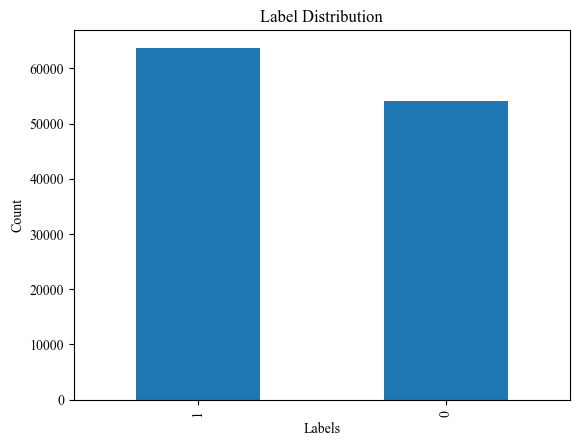

Average length of statements: 13.75 words


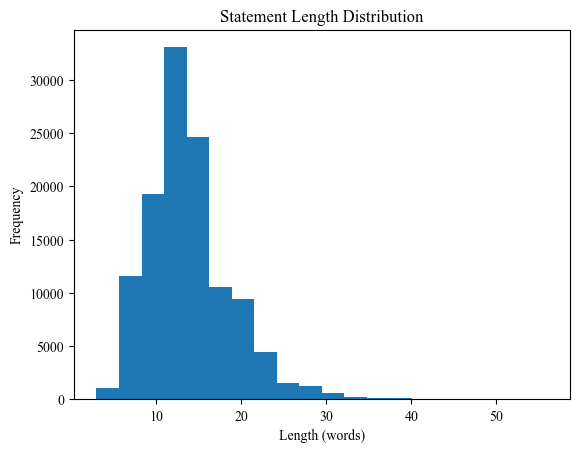

Analyzing table: 2-15401676-3.html.csv
Table ID: 2-15401676-3.html.csv
Shape: (5, 5)
Columns: ['date', 'result', 'score', 'brazil scorers', 'competition']
First few rows:
            date result  score                         brazil scorers  \
0  may 11 , 1919      w  6 - 0  friedenreich (3) , neco (2) , haroldo   
1  may 18 , 1919      w  3 - 1              heitor , amílcar , millon   
2  may 26 , 1919      d  2 - 2                               neco (2)   
3  may 29 , 1919      w  1 - 0                           friedenreich   
4  june 1 , 1919      d  3 - 3                  haroldo , arlindo (2)   

                   competition  
0  south american championship  
1  south american championship  
2  south american championship  
3  south american championship  
4          taça roberto cherry  


In [43]:
# Analyze statements
def analyze_statements(df):
    total_statements = len(df)
    print(f"Total statements: {total_statements}")
    
    # Analyze label distribution
    label_counts = df['label'].value_counts()
    print("\nLabel Distribution:")
    print(label_counts)

    # Visualize label distribution
    label_counts.plot(kind='bar', title="Label Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()

# Analyze statement length
def analyze_statement_length(df):
    statement_lengths = df['statement'].apply(lambda x: len(x.split()))  # Calculate length of each statement
    print(f"Average length of statements: {statement_lengths.mean():.2f} words")
    
    # Visualize statement length distribution
    statement_lengths.plot(kind='hist', bins=20, title="Statement Length Distribution")
    plt.xlabel("Length (words)")
    plt.ylabel("Frequency")
    plt.show()

# Analyze a specific table
def analyze_table_structure(df, table_id):
    # Filter rows for the specific table
    table_data = df[df['table_id'] == table_id]['table_data'].iloc[0]
    table_df = pd.DataFrame(table_data)  # Convert back to DataFrame
    print(f"Table ID: {table_id}")
    print(f"Shape: {table_df.shape}")
    print(f"Columns: {list(table_df.columns)}")
    print(f"First few rows:\n{table_df.head()}")

# Run the updated analyses
print("Training Data Analysis")
analyze_statements(df)
analyze_statement_length(df)

# Analyze a specific table
example_table_id = df['table_id'].iloc[0]  # Get an example table ID
print(f"Analyzing table: {example_table_id}")
analyze_table_structure(df, example_table_id)

### Analysis by metadata

Training Metadata Analysis

Label Distribution by Metadata (Top 10 + Others):
label                                                   0      1
metadata                                                        
none                                                 2508   2914
washington redskins draft history                     161    170
utah jazz all - time roster                           101    127
usa today all - usa high school basketball team       107    119
list of how it 's made episodes                        78    119
atlanta falcons draft history                          79     88
united states house of representatives election...     69     97
1972 vfl season                                        82     83
1979 vfl season                                        72     80
1981 vfl season                                        74     76
Others                                              50800  59850


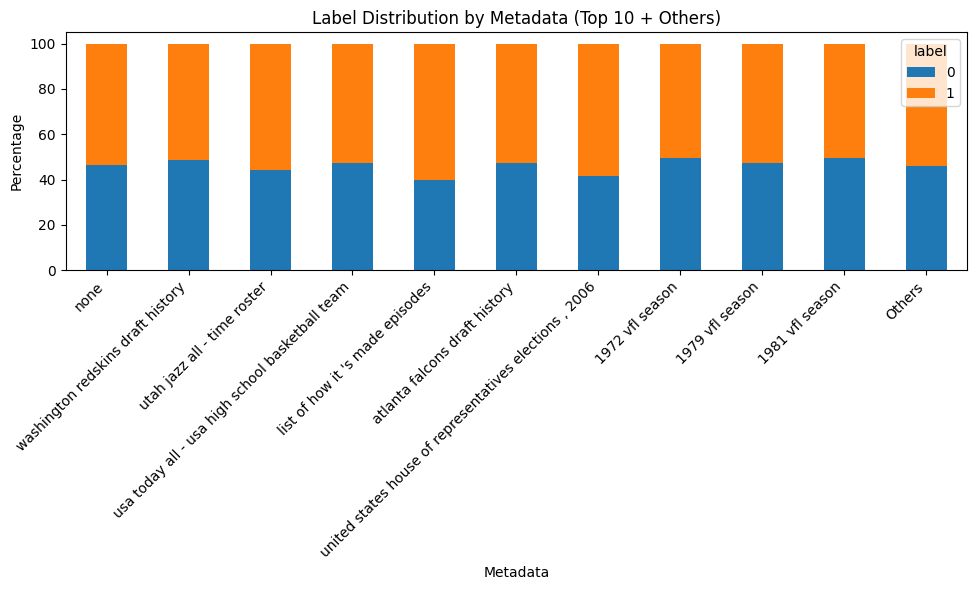


Average Statement Length by Metadata (Top 10):
                                               metadata  statement_length
7435              malta women 's national football team         47.000000
7414                                       magyar rádió         43.000000
3232                 2008 missouri tigers football team         41.000000
4112  awards and decorations of the united states co...         38.333333
9680   wheelchair tennis at the 2004 summer paralympics         35.700000
9174                             the rugby championship         35.000000
6367                                   leonardo tavares         34.200000
7596                          members of the 7th seanad         33.000000
7926  newfoundland and labrador general election , 2011         31.800000
6255                                               kslt         31.600000


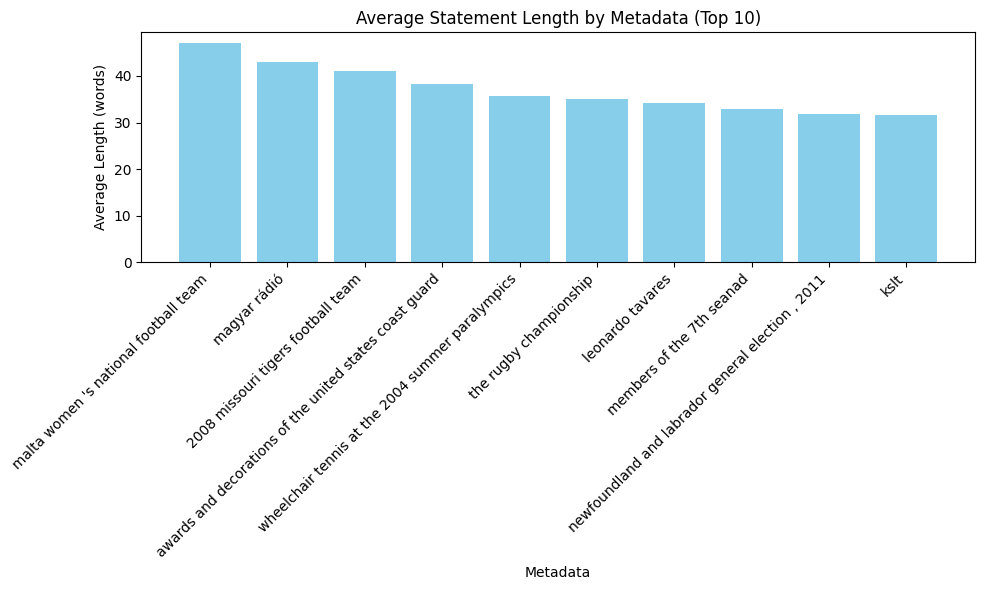

In [17]:
def analyze_label_distribution_by_metadata(df, top_n=10):
    # Count how many statements for each (metadata, label)
    metadata_label_counts = df.groupby(["metadata", "label"]).size().unstack(fill_value=0)

    # Sort metadata by total statements across labels
    metadata_label_counts["Total"] = metadata_label_counts.sum(axis=1)
    metadata_label_counts = metadata_label_counts.sort_values("Total", ascending=False)
    
    # Aggregate the least frequent metadata categories into "Others"
    if len(metadata_label_counts) > top_n:
        top_metadata = metadata_label_counts.head(top_n).index
        others = metadata_label_counts[~metadata_label_counts.index.isin(top_metadata)].sum()
        metadata_label_counts = metadata_label_counts.loc[top_metadata]
        metadata_label_counts.loc["Others"] = others
    
    # Drop the temporary "Total" column
    metadata_label_counts = metadata_label_counts.drop(columns=["Total"], errors="ignore")

    print("\nLabel Distribution by Metadata (Top {} + Others):".format(top_n))
    print(metadata_label_counts)
    
    # Convert to percentages for better comparison
    metadata_label_counts_percent = metadata_label_counts.div(metadata_label_counts.sum(axis=1), axis=0) * 100

    # Plot
    ax = metadata_label_counts_percent.plot(
        kind='bar', 
        stacked=True, 
        figsize=(10, 6),
        title="Label Distribution by Metadata (Top {} + Others)".format(top_n)
    )
    ax.set_xlabel("Metadata")
    ax.set_ylabel("Percentage")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def analyze_statement_length_by_metadata(df, top_n=10):
    # Calculate statement length
    df['statement_length'] = df['statement'].str.split().apply(len)

    # Average length grouped by metadata
    avg_length_by_metadata = df.groupby('metadata')['statement_length'].mean().reset_index()
    avg_length_by_metadata = avg_length_by_metadata.sort_values('statement_length', ascending=False)

    # Keep top_n
    if len(avg_length_by_metadata) > top_n:
        avg_length_by_metadata_top = avg_length_by_metadata.head(top_n)
    else:
        avg_length_by_metadata_top = avg_length_by_metadata

    print("\nAverage Statement Length by Metadata (Top {}):".format(top_n))
    print(avg_length_by_metadata_top)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(
        avg_length_by_metadata_top['metadata'], 
        avg_length_by_metadata_top['statement_length'], 
        color='skyblue'
    )
    plt.title("Average Statement Length by Metadata (Top {})".format(top_n))
    plt.xlabel("Metadata")
    plt.ylabel("Average Length (words)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the updated analyses
print("Training Metadata Analysis")
analyze_label_distribution_by_metadata(df)
analyze_statement_length_by_metadata(df)

## Analysis of table content:


Table Structure Summary:
            num_rows       num_cols
count  117854.000000  117854.000000
mean       13.431313       6.310740
std         8.579322       1.658093
min         1.000000       5.000000
25%         7.000000       5.000000
50%        11.000000       6.000000
75%        17.000000       7.000000
max        48.000000      43.000000


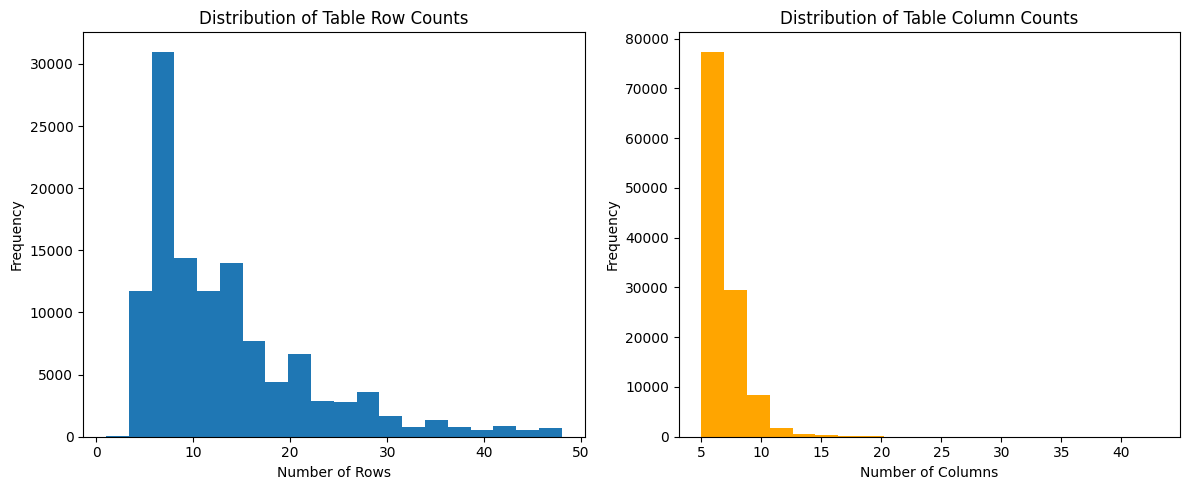

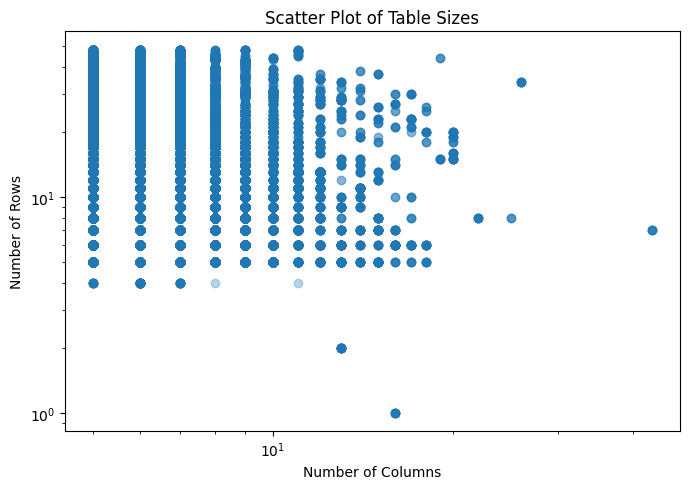

In [8]:
def analyze_table_content(df):
    # Extract number of rows and columns
    table_shapes = df['table_data'].apply(
        lambda x: (len(x), len(x[0]) if len(x) > 0 else 0)
    )
    df['num_rows'], df['num_cols'] = zip(*table_shapes)

    # Print summary
    print("\nTable Structure Summary:")
    print(df[['num_rows', 'num_cols']].describe())

    # Plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    df['num_rows'].plot(
        kind='hist',
        bins=20,
        title="Distribution of Table Row Counts",
        ax=axes[0]
    )
    axes[0].set_xlabel("Number of Rows")
    axes[0].set_ylabel("Frequency")

    df['num_cols'].plot(
        kind='hist',
        bins=20,
        title="Distribution of Table Column Counts",
        ax=axes[1],
        color='orange'
    )
    axes[1].set_xlabel("Number of Columns")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # (Optional) Scatter plot
    plt.figure(figsize=(7, 5))
    plt.scatter(df['num_cols'], df['num_rows'], alpha=0.3)
    plt.title("Scatter Plot of Table Sizes")
    plt.xlabel("Number of Columns")
    plt.ylabel("Number of Rows")
    plt.xscale("log")  # if you want log scale
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

# Run the updated analyses
analyze_table_content(df)


Top 10 Tables by Number of Statements:
table_id
1-26757-4.html.csv        27
1-15555661-2.html.csv     24
1-26160007-1.html.csv     24
2-12771946-3.html.csv     24
1-13741576-6.html.csv     23
2-10809271-14.html.csv    23
2-18942405-9.html.csv     23
1-10236830-6.html.csv     23
2-1296513-5.html.csv      23
2-1375378-3.html.csv      23
dtype: int64


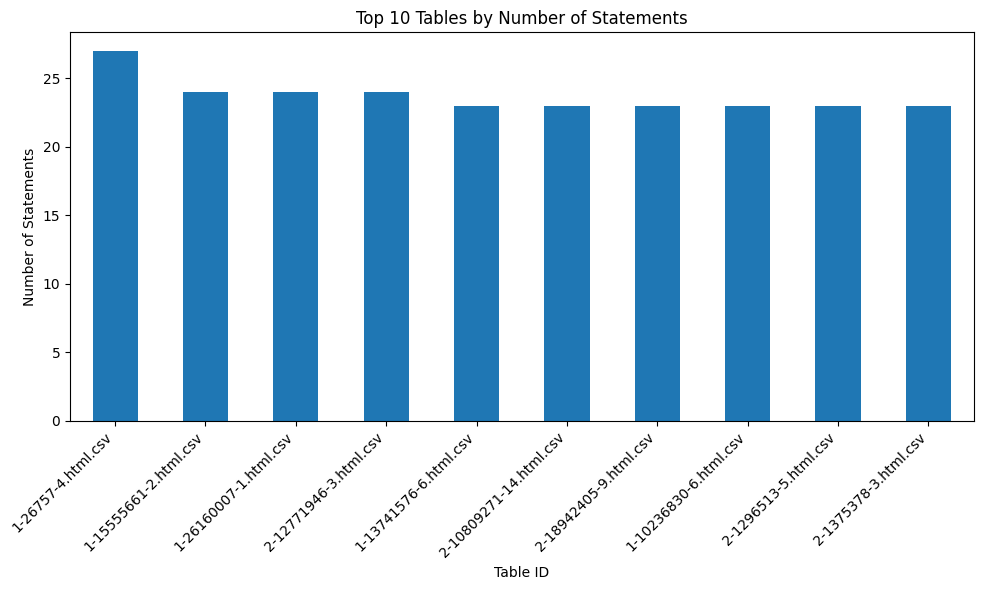

In [10]:
def analyze_statements_per_table(df, top_n=10):
    # Count how many statements each table has
    counts = df.groupby('table_id').size().sort_values(ascending=False)
    
    print(f"\nTop {top_n} Tables by Number of Statements:")
    print(counts.head(top_n))
    
    # Plot top N as a bar chart
    top_counts = counts.head(top_n)
    plt.figure(figsize=(10, 6))
    top_counts.plot(kind='bar')
    plt.title(f"Top {top_n} Tables by Number of Statements")
    plt.xlabel("Table ID")
    plt.ylabel("Number of Statements")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the updated analyses
analyze_statements_per_table(df)

### Correlation Between Statement Length and Label

Do people write longer statements for “true” vs. “false” claims?


Statement Length by Label:
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      54131.0  13.794351  4.950747  3.0  10.0  13.0  16.0  56.0
1      63723.0  13.712820  4.998544  4.0  10.0  13.0  16.0  55.0


<Figure size 600x500 with 0 Axes>

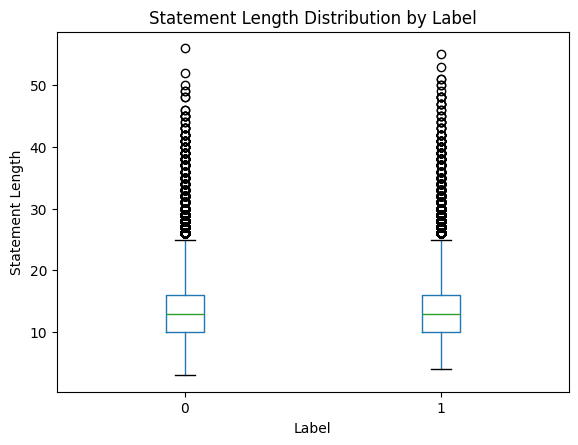

In [9]:
def analyze_correlation_statement_length_label(df):
    # Create a numeric statement length column
    df['statement_length'] = df['statement'].str.split().apply(len)

    # Group by label
    length_by_label = df.groupby('label')['statement_length'].describe()
    print("\nStatement Length by Label:")
    print(length_by_label)

    # Box plot to visualize the distribution
    plt.figure(figsize=(6, 5))
    df.boxplot(column='statement_length', by='label', grid=False)
    plt.title("Statement Length Distribution by Label")
    plt.suptitle("")  # Remove default subplot title
    plt.xlabel("Label")
    plt.ylabel("Statement Length")
    plt.show()

analyze_correlation_statement_length_label(df)

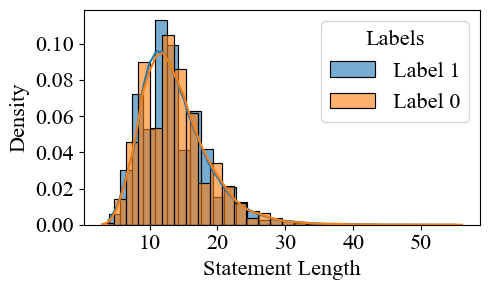

In [8]:
fontsize = 16
def plot_statement_length_distribution(df):
    # Create a numeric statement length column
    df['statement_length'] = df['statement'].str.split().apply(len)

    # Plot overlapping histograms
    plt.figure(figsize=(5, 3))  # Half-page width for LaTeX
    labels = df['label'].unique()
    
    for label in labels:
        sns.histplot(df[df['label'] == label]['statement_length'], 
                     label=f"Label {label}", 
                     kde=True, 
                     stat="density", 
                     common_norm=False, 
                     bins=30, 
                     alpha=0.6)

    # Customize the plot
    #plt.title("Statement Length Distribution by Label", fontsize=fontsize+2)
    plt.xlabel("Statement Length", fontsize=fontsize)
    plt.ylabel("Density", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(title="Labels", fontsize=fontsize, title_fontsize=fontsize)
    plt.grid(visible=False)

    # Adjust layout
    plt.tight_layout()

    # Save the figure in a high-quality format for LaTeX
    plt.savefig("plots/statement_length_distribution.pdf", format="pdf", dpi=300)

# Call the function
plot_statement_length_distribution(df)

## Distribution of Unique Words Across Statements

[nltk_data] Downloading package punkt to /Users/luka512/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Unique Word Statistics by Label (True/False):
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      54131.0  12.577396  3.848034  3.0  10.0  12.0  15.0  40.0
1      63723.0  12.481553  3.840899  3.0  10.0  12.0  15.0  41.0


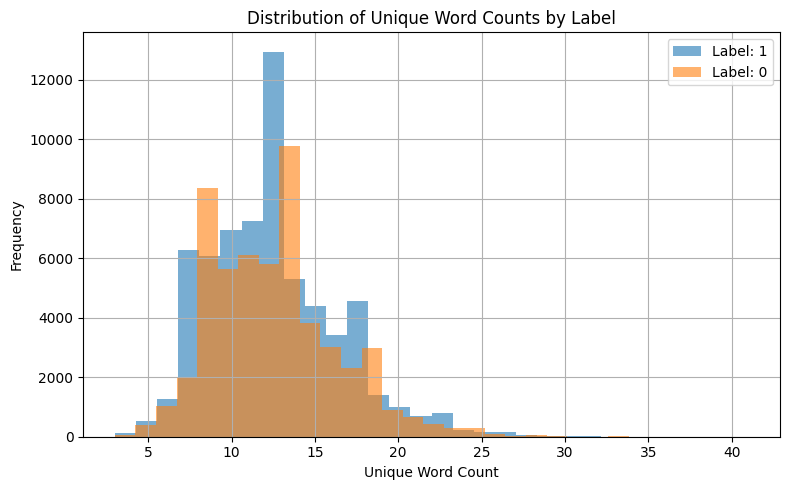

In [16]:
def analyze_unique_words_by_label(df):

    # Helper function to count unique words in a statement
    def get_unique_word_count(statement):
        tokens = nltk.word_tokenize(statement)
        return len(set(tokens))

    # Add a column for unique word counts
    df['unique_words'] = df['statement'].apply(get_unique_word_count)

    # Group by label and describe the unique words
    unique_word_stats = df.groupby('label')['unique_words'].describe()
    print("\nUnique Word Statistics by Label (True/False):")
    print(unique_word_stats)

    # Histogram for each label
    labels = df['label'].unique()
    plt.figure(figsize=(12, 6))
    for label in labels:
        subset = df[df['label'] == label]
        subset['unique_words'].hist(
            bins=30, alpha=0.6, label=f"Label: {label}", figsize=(8, 5)
        )
    plt.title("Distribution of Unique Word Counts by Label")
    plt.xlabel("Unique Word Count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the updated analyses
analyze_unique_words_by_label(df)

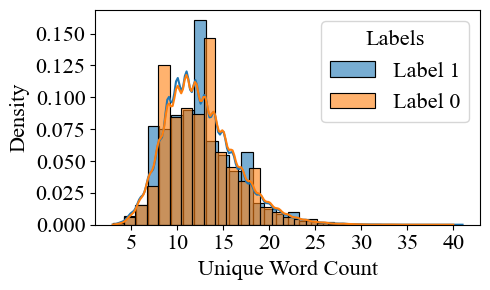

In [9]:
def plot_unique_word_distribution(df):
    # Helper function to count unique words in a statement
    def get_unique_word_count(statement):
        tokens = nltk.word_tokenize(statement)
        return len(set(tokens))

    # Add a column for unique word counts
    df['unique_words'] = df['statement'].apply(get_unique_word_count)

    # Plot overlapping histograms
    plt.figure(figsize=(5, 3))  # Half-page width for LaTeX
    labels = df['label'].unique()
    
    for label in labels:
        sns.histplot(df[df['label'] == label]['unique_words'], 
                     label=f"Label {label}", 
                     kde=True, 
                     stat="density", 
                     common_norm=False, 
                     bins=30, 
                     alpha=0.6)

    # Customize the plot
    plt.xlabel("Unique Word Count", fontsize=fontsize)
    plt.ylabel("Density", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(title="Labels", fontsize=fontsize, title_fontsize=fontsize)
    plt.grid(visible=False)

    # Adjust layout
    plt.tight_layout()

    # Save the figure in a high-quality format for LaTeX
    plt.savefig("plots/unique_word_distribution.pdf", format="pdf", dpi=300)

# Call the function
plot_unique_word_distribution(df)

### Top N Words in Statements


Top 20 Most Common Words in Statements:
game: 15946
team: 12732
score: 11385
play: 10285
win: 9524
time: 7299
season: 6864
point: 6398
player: 6076
number: 5925
year: 5301
highest: 4898
total: 4516
episode: 4237
home: 4081
attendance: 3807
place: 3797
record: 3786
match: 3367
first: 3361


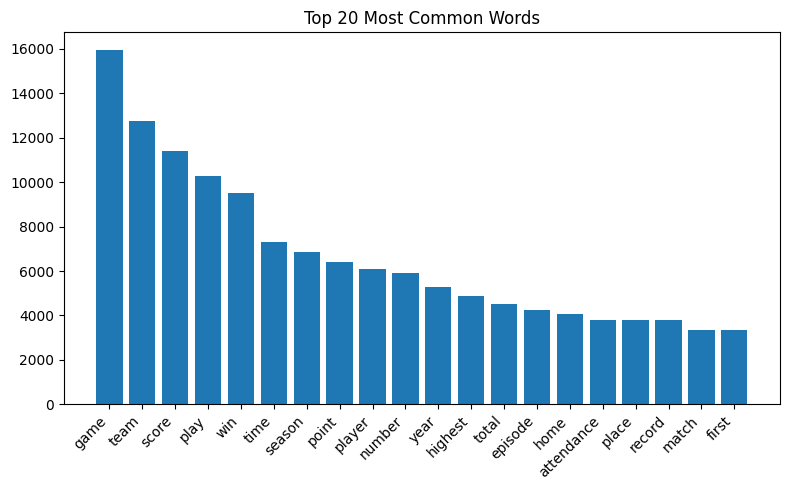

In [15]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Make sure to download stopwords if you haven't yet:
# nltk.download('stopwords')

def analyze_most_common_words(df, top_n=20):
    stop_words = set(stopwords.words('english'))
    all_words = []
    
    for statement in df['statement']:
        tokens = nltk.word_tokenize(statement.lower())
        # Filter out punctuation, stopwords, etc.
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        all_words.extend(tokens)

    word_counts = Counter(all_words)
    top_words = word_counts.most_common(top_n)
    
    print(f"\nTop {top_n} Most Common Words in Statements:")
    for word, freq in top_words:
        print(f"{word}: {freq}")

    # (Optional) Plot them
    words, freqs = zip(*top_words)
    plt.figure(figsize=(8,5))
    plt.bar(words, freqs)
    plt.title(f"Top {top_n} Most Common Words")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Run the updated analyses
analyze_most_common_words(df)